In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags
from scipy.sparse import csr_matrix
from scipy.integrate import solve_ivp
from scipy.linalg import lu, solve
from scipy.sparse.linalg import gmres
from scipy.sparse.linalg import bicgstab
from scipy.linalg import lu, solve_triangular
from scipy.fftpack import fft2, ifft2
from scipy.sparse.linalg import spsolve

### creating matrices

m = 64 # N value in x and y directions
n = m * m # total size of matrix
deltax = 20/m
deltaS = (20/m) **2

e0 = np.zeros((n, 1)) # vector of zeros
e1 = np.ones((n, 1)) # vector of ones

e2 = np.copy(e1) # copy the one vector
e4 = np.copy(e0) # copy the zero vector

for j in range(1, m+1):
    e2[m*j-1] = 0 # overwrite every m^th value with zero
    e4[m*j-1] = 1 # overwirte every m^th value with one
    
# Shift to correct positions
e3 = np.zeros_like(e2)
e3[1:n] = e2[0:n-1]
e3[0] = e2[n-1]

e5 = np.zeros_like(e4)
e5[1:n] = e4[0:n-1]
e5[0] = e4[n-1]

diagonals = [e1.flatten(), e1.flatten(), e5.flatten(),
e2.flatten(), -4 * e1.flatten(), e3.flatten(),
e4.flatten(), e1.flatten(), e1.flatten()]
offsets = [-(n-m), -m , -(m-1), -1, 0, 1, m - 1, m , (n-m)]
matA = spdiags(diagonals, offsets, n, n).tocsr()


A = matA.toarray()
A = A / deltaS

matA = matA/deltaS
A_w_0_changed = matA.toarray()
A_w_0_changed[0,0] = 2

### dy

diagonalsC = [e5.flatten(), -1 * e2.flatten(), e3.flatten(), -1 * e4.flatten()]
offsetsC = [-(m-1),-1,1,m-1]
matC = spdiags(diagonalsC, offsetsC, n, n)


C = matC.toarray() 
C = C/ (2 * deltax)

matC = matC/ (2 * deltax)

### dx

diagonalsB = [e1.flatten()/  (2 * deltax), -1 * e1.flatten()/ (2 * deltax), e1.flatten()/ (2 * deltax), -1 * e1.flatten()/ (2 * deltax)]
offsetsB = [-(n-m),-m,m, n-m]
matB = spdiags(diagonalsB, offsetsB, n, n)

B = matB.toarray()
    

In [2]:
### fft solve

def fft(w0, tspan, n):
    v = 0.001
    nx, ny = n, n
    N = nx * ny
    
    ## spectral k values
    kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0,nx/2), np.arange(-nx/2, 0)))
    ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0,ny/2), np.arange(-ny/2, 0)))
    kx[0] = 1e-6
    ky[0] = 1e-6
    
    KX, KY = np.meshgrid(kx,ky)
    K = KX**2 + KY**2
    
    def fft_rhs(t, w, nx, ny, N, K, matA, matB, matC):
        wrv = np.real(w)
        wfft = fft2(w0)
        psi_ft = -wfft / K
        psiV = np.real(ifft2(psi_ft)).reshape((nx **2,))
        
        return ((v * matA.dot(w)) - (matB.dot(psiV)) * (matC.dot(w)) + (matC.dot(psiV)) * (matB.dot(w)))
            
    
    sol_ft = solve_ivp(fft_rhs, (tspan[0],tspan[-1]), wrv, method='RK45', t_eval=tspan, args = (nx, ny, N, K, matA, matB, matC))
    return sol_ft.y

In [3]:
## initial conditions & calling A1
n = 64
v = 0.001
Lx,Ly = 20,20
nx, ny = n, n
N = nx * ny
tspan = np.linspace(0,4, 8 + 1)


X = np.linspace(-10,10,n+1)
Y = np.linspace(-10,10,n+1)
x = X[:n]
y = Y[:n]
x1, y1 = np.meshgrid(x, y)

w0 = 1 * np.exp((-x1**2) -((y1**2)/20)) + 1j * np.zeros((nx,ny))
wv = w0.reshape(nx **2,)
wrv = np.real(wv)

A1 = fft(w0, tspan, n)
print(A1.shape)

(4096, 9)


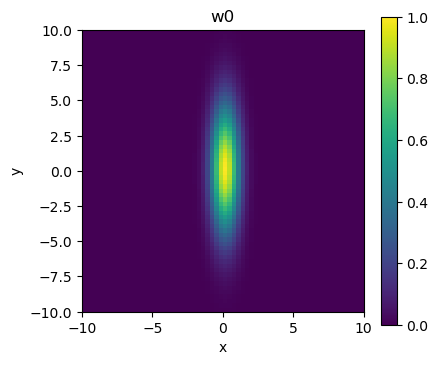

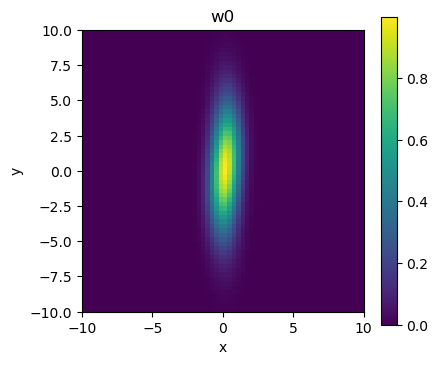

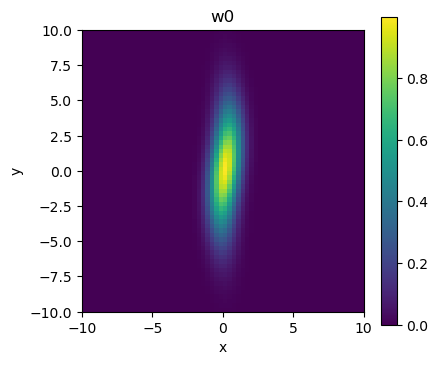

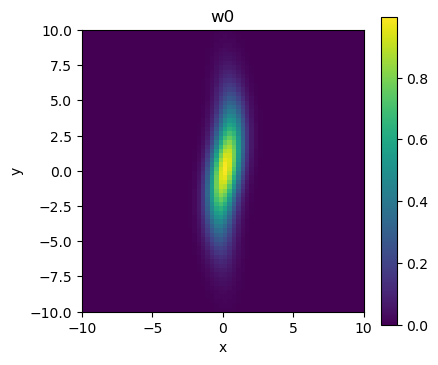

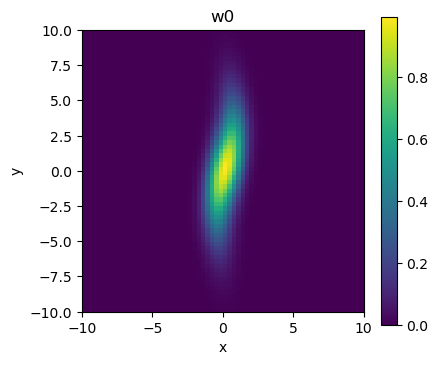

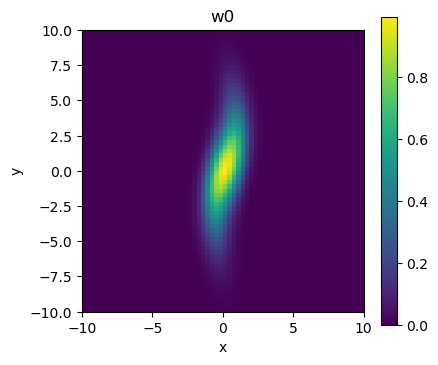

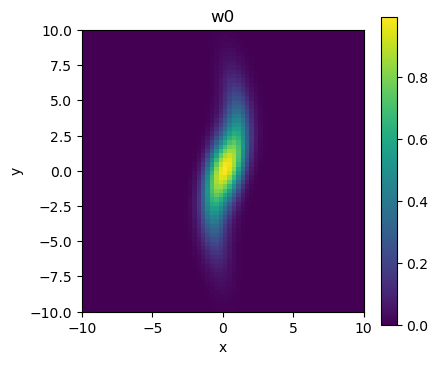

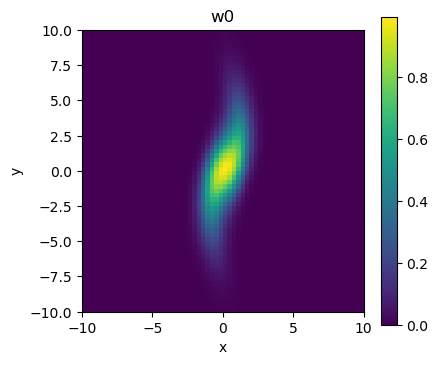

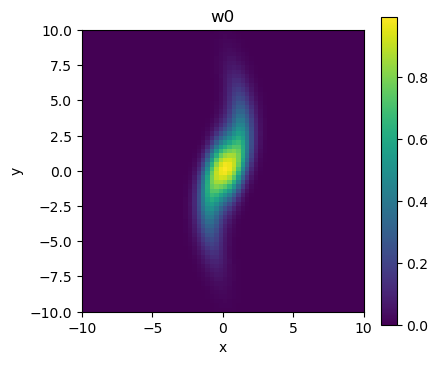

In [4]:
for j in range (9):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(A1[:,j].reshape(n,n), extent=(-10, 10, -10, 10), origin='lower', cmap='viridis')
    plt.colorbar()
    plt.title('w0')
    plt.xlabel('x')
    plt.ylabel('y')

In [5]:
### A / b

n = 64
l = 4
dl = 0.5
v = 0.001
tspan = np.linspace(0,l, 8 + 1)

X = np.linspace(-10,10,n+1)
Y = np.linspace(-10,10,n+1)

x = X[:n]
y = Y[:n]

x1, y1 = np.meshgrid(x, y)

w = np.exp((-x1**2) -((y1**2)/20))
deltaS = (20/n) **2

### A/ B


def a_b(w, tspan, n):
    matA[0,0] = 2/deltaS
    
    A_w_0_changed = matA.toarray()
    A_w_0_changed[0,0] = 2/ deltaS
    
    nx, ny = n, n
    N = nx * ny
    wVec = w.reshape(n**2,)
    
    def a_b_rhs(t, w, nx, ny, matA, matB, matC):
        psi_ab = spsolve(matA, w)
        
        return ((v * matA.dot(w)) - (matB.dot(psi_ab)) * (matC.dot(wVec)) + (matC.dot(psi_ab)) * (matB.dot(wVec)))
            
   
    sol_ab = solve_ivp(a_b_rhs, (tspan[0],tspan[-1]), wVec, method='RK45', t_eval=tspan, args = (nx, ny, matA, matB, matC))
    return sol_ab.y
       

(4096, 9)


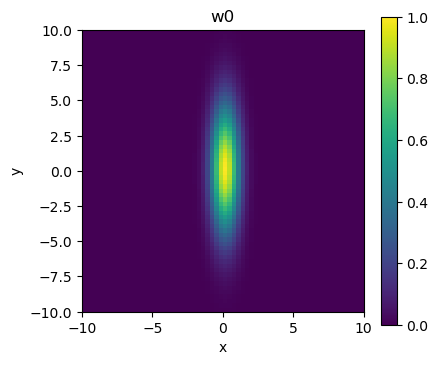

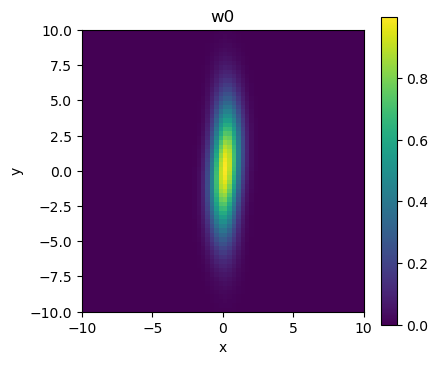

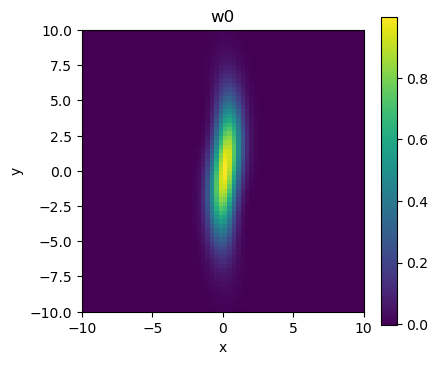

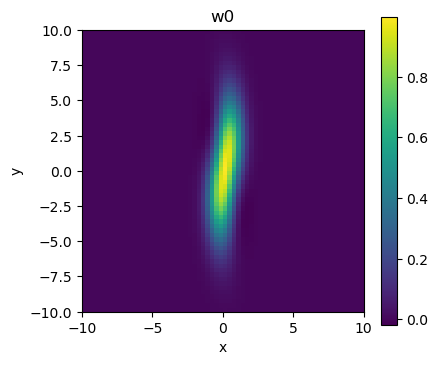

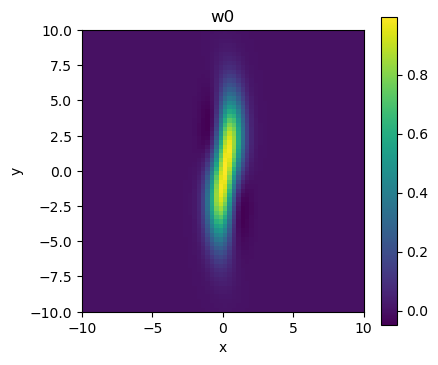

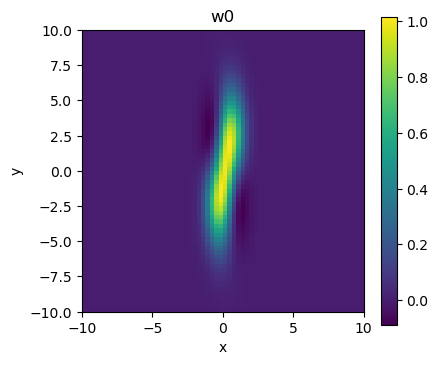

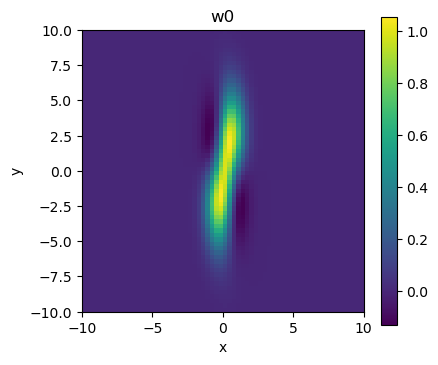

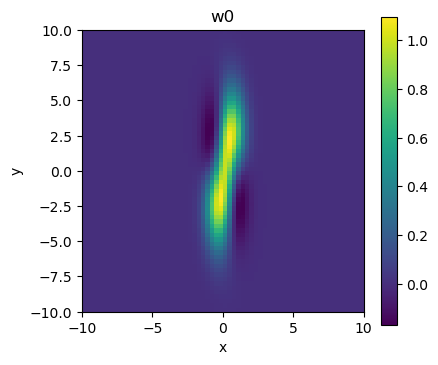

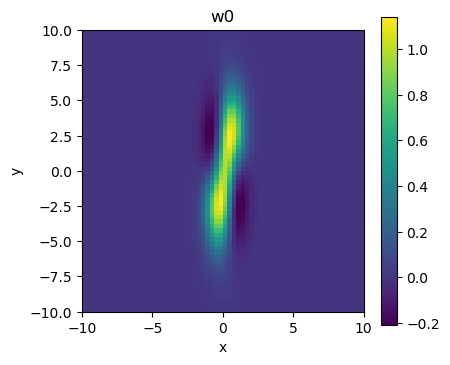

In [6]:
A2 = a_b(w, tspan, n)
print(A2.shape)
for j in range (9):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(A2[:,j].reshape(n,n), extent=(-10, 10, -10, 10), origin='lower', cmap='viridis')
    plt.colorbar()
    plt.title('w0')
    plt.xlabel('x')
    plt.ylabel('y')

In [23]:

### lu decomp

n = 64
l = 4
dl = 0.5
v = 0.001
tspan = np.linspace(0,l, 8 + 1)
X = np.linspace(-10,10,n+1)
Y = np.linspace(-10,10,n+1)

x = X[:n]
y = Y[:n]

x1, y1 = np.meshgrid(x, y)

w0_lu = np.exp((-x1**2) -((y1**2)/20))

A[0,0] = 2/deltaS

P, L, U = lu(A)
deltax = 20/n
deltaS = (20/n) **2

def L_U(w0_lu, tspan, n):
    
    matA[0,0] = 2/deltaS
    
    wVec_lu = w0_lu.reshape(n**2,)
    print("wVec_lu", wVec_lu)
    
    def lu_rhs(t, w, P, L, U, matA, matB, matC):
        
        Pb = np.dot(P, w)
        SOL = solve_triangular(L, Pb, lower=True)
        psi_lu = solve_triangular(U, SOL)
        
        return ((v * matA.dot(w)) - (matB.dot(psi_lu)) * (matC.dot(w)) + (matC.dot(psi_lu)) * (matB.dot(w)))
    
    sol = solve_ivp(lu_rhs, (tspan[0],tspan[-1]), wVec_lu, method='RK45', t_eval=tspan, args = (P, L, U, matA, matB, matC))
    # print("sol.y", sol.y.)
   
    
    return sol.y

wVec_lu [2.50656748e-46 1.17762859e-43 4.55107657e-41 ... 1.96785570e-38
 6.19028421e-41 1.60178709e-43]
(4096, 9)


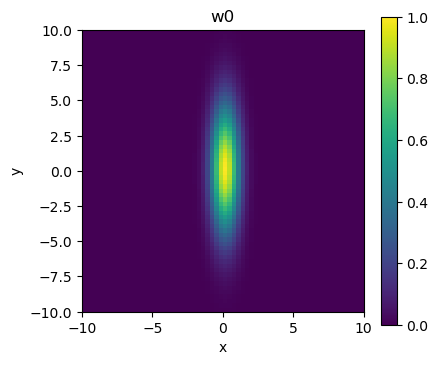

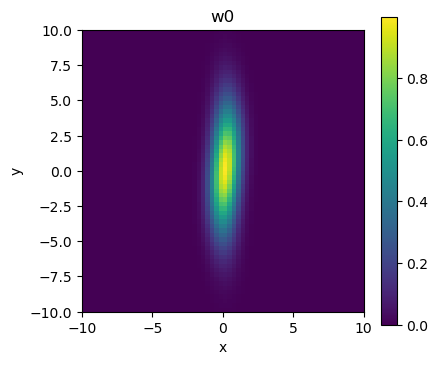

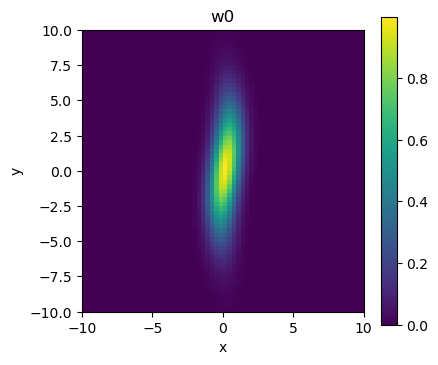

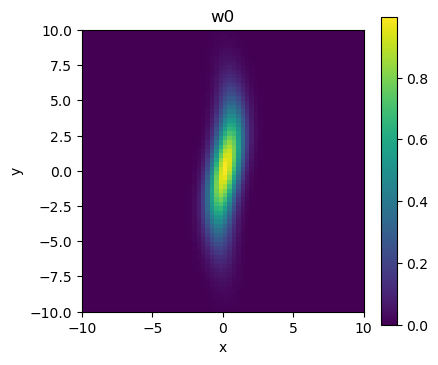

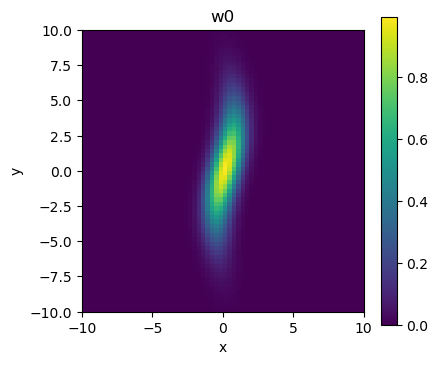

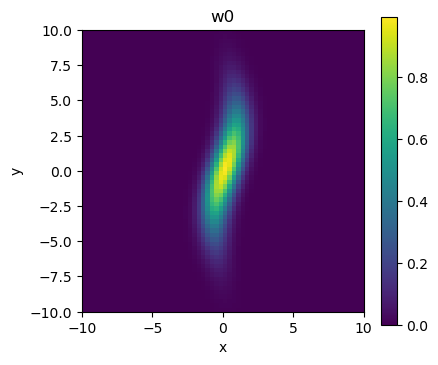

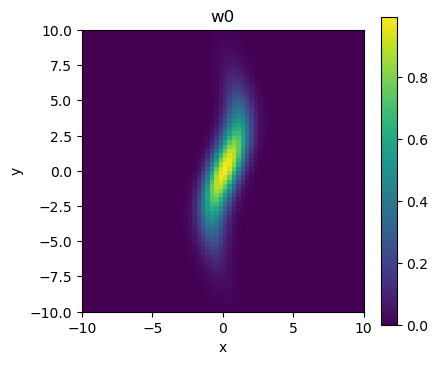

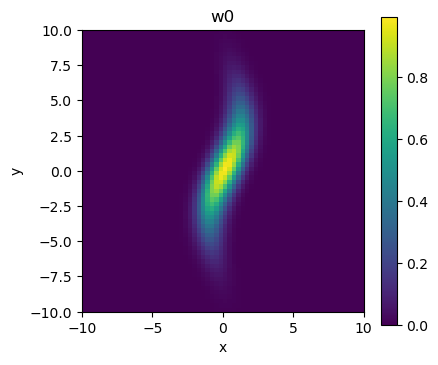

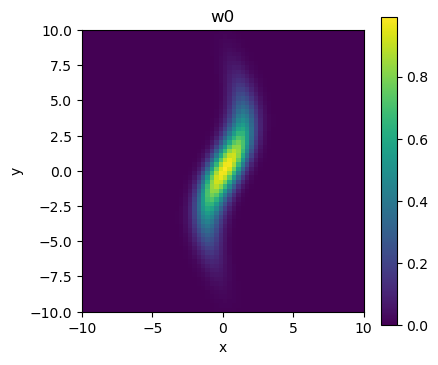

In [25]:
A3 = L_U(w0_lu, tspan, n)
print(A3.shape)

for j in range (9):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(A3[:,j].reshape(n,n), extent=(-10, 10, -10, 10), origin='lower', cmap='viridis')
    plt.colorbar()
    plt.title('w0')
    plt.xlabel('x')
    plt.ylabel('y')

In [27]:
print("A1", A1)
print("A2", A2)
print("A3", A3)

A1 [[2.50656748e-46 3.48063575e-45 1.71453450e-44 ... 1.26385625e-42
  2.77691259e-42 5.62632594e-42]
 [1.17762859e-43 6.39193972e-43 2.43137292e-42 ... 9.16253901e-41
  1.70616965e-40 2.91399143e-40]
 [4.55107657e-41 1.88422921e-40 5.89994899e-40 ... 1.25509208e-38
  2.04631920e-38 3.04073020e-38]
 ...
 [1.96785570e-38 1.18794621e-37 4.88612220e-37 ... 2.15263665e-35
  4.04164392e-35 6.87836697e-35]
 [6.19028421e-41 5.09475989e-40 2.56689028e-39 ... 1.97260117e-37
  4.13058977e-37 7.79842584e-37]
 [1.60178709e-43 1.92189741e-42 1.16225865e-41 ... 1.67122560e-39
  3.97857525e-39 8.47953397e-39]]
A2 [[2.50656748e-46 3.56541862e-45 1.79002688e-44 ... 1.40566116e-42
  3.56165020e-42 8.31317549e-42]
 [1.17762859e-43 6.52082796e-43 2.55530114e-42 ... 1.28549535e-40
  2.92709018e-40 6.24345386e-40]
 [4.55107657e-41 1.93449943e-40 6.36843173e-40 ... 2.14424166e-38
  4.46349039e-38 8.81332021e-38]
 ...
 [1.96785570e-38 4.13228849e-36 1.16566403e-35 ... 1.46817077e-34
  2.45271385e-34 3.9878766